# Przygotowanie środowiska

In [ ]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

/content
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
'Biwak miejsca.gmap'   data_for_train	       'Google Earth'
'Colab Notebooks'     'Forgotten places.gmap'  'My Drive'


Doinstalowanie dodatkowych pakietów do frameworka TensorFlow.

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-fdbmzzzw
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-fdbmzzzw
  Created wheel for tensorflow-examples: filename=tensorflow_examples-22f86fd27e5688152772e06db80da03d552bfd10_-cp36-none-any.whl size=164233 sha256=313c8729b87d634ca787acad359af85c6eedc172a70d41485125bbe75f3df972
  Stored in directory: /tmp/pip-ephem-wheel-cache-vwent221/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


Tworzenie lokalizacji dla danych testowych, oraz klonowanie danych z dysku.

In [ ]:
!mkdir data
!mkdir data/coin_mask
!mkdir data/coin
!cp /mydrive/data_for_train/coins/obj.zip ../
!unzip ../obj.zip -d data/

Archive:  ../obj.zip
   creating: data/obj/
  inflating: data/obj/20201211_200236.txt  
  inflating: data/obj/classes.txt    
  inflating: data/obj/IMG_20201211_190633.jpg  
  inflating: data/obj/IMG_20201211_190633.txt  
  inflating: data/obj/IMG_20201211_190708.jpg  
  inflating: data/obj/IMG_20201211_190708.txt  
  inflating: data/obj/IMG_20201211_190736.jpg  
  inflating: data/obj/IMG_20201211_190736.txt  
  inflating: data/obj/IMG_20201211_190810.jpg  
  inflating: data/obj/IMG_20201211_190810.txt  
  inflating: data/obj/IMG_20201211_191547.jpg  
  inflating: data/obj/IMG_20201211_191547.txt  
  inflating: data/obj/IMG_20201211_191710.jpg  
  inflating: data/obj/IMG_20201211_191710.txt  
  inflating: data/obj/IMG_20201211_191729.jpg  
  inflating: data/obj/IMG_20201211_191729.txt  
  inflating: data/obj/IMG_20201211_191816.jpg  
  inflating: data/obj/IMG_20201211_191816.txt  
  inflating: data/obj/IMG_20201211_191835.jpg  
  inflating: data/obj/IMG_20201211_191835.txt  
  inflatin

Pobranie skryptu dzielącego zdjęcia z zestawami monet na poszczególne monety. Lokalizacje mask na zdjęciach zapisane są w pliku .json, a następnie na ich podstawie tworzone są maski.

In [ ]:
%cd data
!cp /mydrive/data_for_train/create_masks.py ./
!cp /mydrive/data_for_train/coins/coins.json ./
!python3 create_masks.py

Wymagane importy bibliotek

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.4.0


In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix
import numpy as np
import os

from IPython.display import clear_output
import matplotlib.pyplot as plt
import cv2

# Preparowanie danych trenujacych
Zdjęcia należy przerobić tak aby mogły być użyte przez sieć. Należy zmienić ich rozmiar na ten używany w sieci. Dobrą praktyką jest również ustandaryzowanie danych wejściowych tak aby maksymalna wartościa wejściową była jedynka, w tym celu cały obraz jest dzielony przez 255.

In [ ]:
def outputPrepare(img_y):
  img_y = img_y[:,:,0]
  img_y = img_y.reshape(img_y.shape[0], img_y.shape[1], 1)
  img_y = cv2.resize(img_y, (128, 128))
  _, img_y = cv2.threshold(img_y, 20, 255, cv2.THRESH_BINARY) # remove pixel changing after reshape
  img_y = img_y/255
  return img_y.reshape(128, 128, 1)

In [ ]:
def inputPrepare(img_x):
  img_x = cv2.resize(img_x, (128, 128))
  return img_x/255

Mając już funkcje preparujące zdjęcia, należy stworzyć tablice zawierającą wszystkie dane wejściowe i wyjściowe sieci.

In [ ]:
files = []
for filename in os.listdir(os.getcwd()+"/coin_mask"):
  if filename.endswith(".jpg"):
    files.append(filename[:-4])
train_x = []
train_y = []
for name in files:
  img_x = cv2.imread("./coin/"+name+".jpg")
  img_y = cv2.imread("./coin_mask/"+name+".jpg")
  img_x = inputPrepare(img_x)
  img_y = outputPrepare(img_y)
  train_x.append(img_x)
  train_y.append(img_y)

In [ ]:
test_x = np.asarray(train_x) # input data
test_y = np.asarray(train_y) # output data

# Definiowanie modelu
Do segmentacji monet na obrazie została wybrana sieć uNet. Składa się ona z kilku stróktór dekoderów/enkoderów. Nazwa sieci pochodzi od kształtu powstałej w ten sposób struktury.

In [ ]:
OUTPUT_CHANNELS = 2

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples.

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

# Trenowanie modelu
Kompilacja modelu

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Struktura sieci graficznie wygląda w następujący sposób

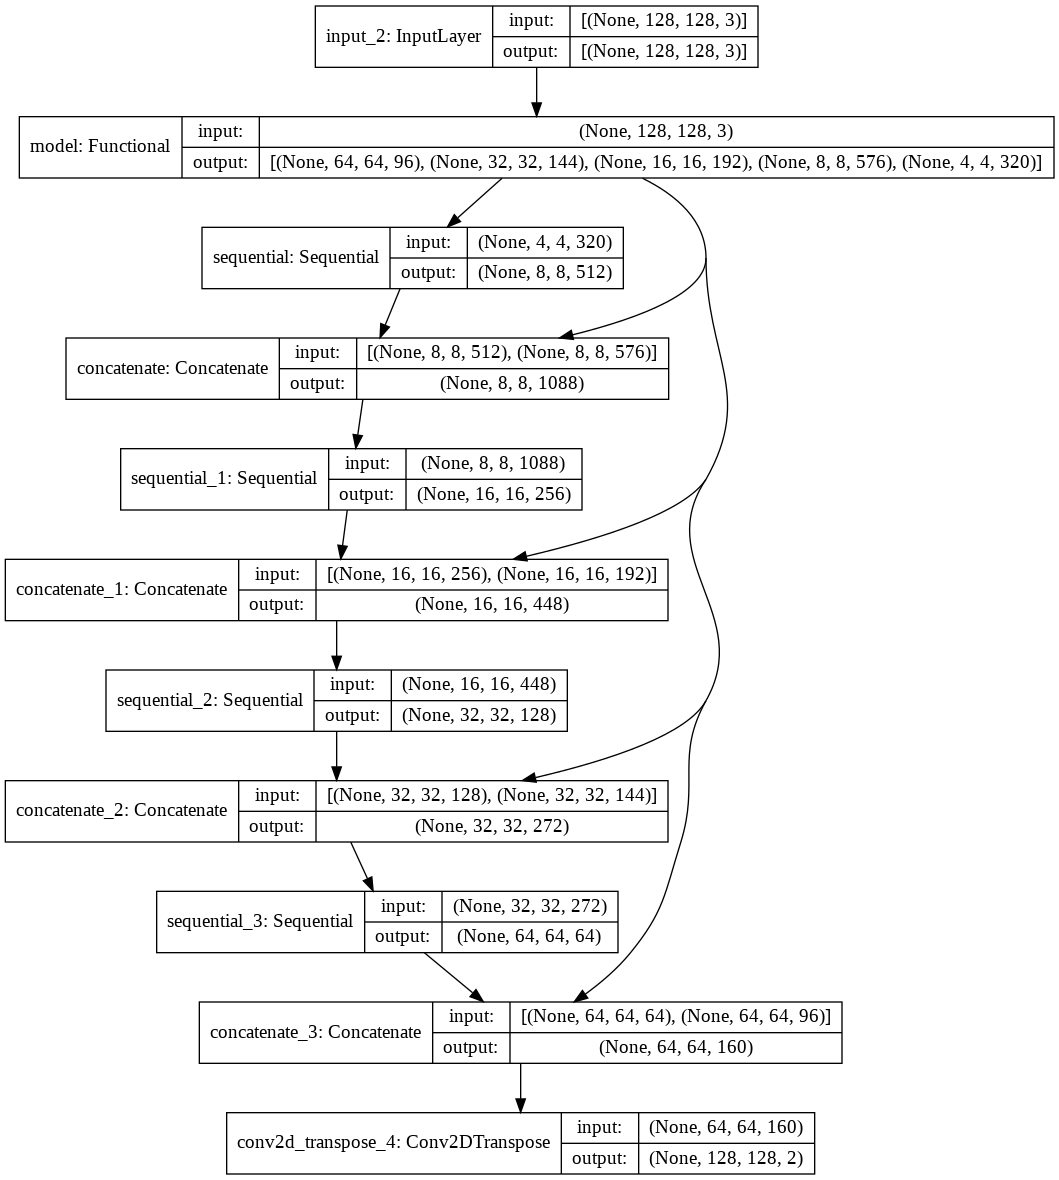

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

Trenowanie sieci

In [ ]:
EPOCHS = 100
model_history = model.fit(x=test_x, y=test_y, batch_size=64, epochs=EPOCHS, verbose=1)

Epoch 1/100
16/16 [==============================] - 2s 105ms/step - loss: 0.0166 - accuracy: 0.9932
Epoch 2/100
16/16 [==============================] - 2s 103ms/step - loss: 0.0142 - accuracy: 0.9942
Epoch 3/100
16/16 [==============================] - 2s 104ms/step - loss: 0.0130 - accuracy: 0.9947
Epoch 4/100
16/16 [==============================] - 2s 104ms/step - loss: 0.0134 - accuracy: 0.9947
Epoch 5/100
16/16 [==============================] - 2s 104ms/step - loss: 0.0139 - accuracy: 0.9943
Epoch 6/100
16/16 [==============================] - 2s 104ms/step - loss: 0.0178 - accuracy: 0.9926
Epoch 7/100
16/16 [==============================] - 2s 104ms/step - loss: 0.0140 - accuracy: 0.9942
Epoch 8/100
16/16 [==============================] - 2s 105ms/step - loss: 0.0127 - accuracy: 0.9949
Epoch 9/100
16/16 [==============================] - 2s 105ms/step - loss: 0.0115 - accuracy: 0.9954
Epoch 10/100
16/16 [==============================] - 2s 105ms/step - loss: 0.0119 - accura

Funkcja pokazująca  spadek funkcji błędu na przestrzeni epok. Poniższy wykres praktycznie się nie zmienia, ponieważ sieć była "dotrenowywania" któryś raz z rzędu, aż do małych zmian funkcji błędu.

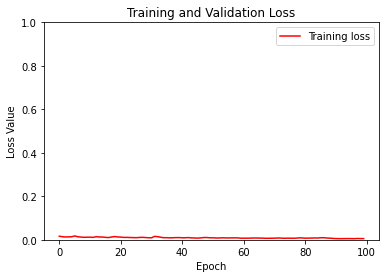

In [ ]:
loss = model_history.history['loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

Zapisanie wytrenowanych wag na dysku Google. Można je później użyć do "dotrenowania" sieci. Będą również potrzebne do operacji na obrazach.

In [ ]:
model.save('/mydrive/data_for_train/coins/u_net')

INFO:tensorflow:Assets written to: /mydrive/data_for_train/coins/u_net/assets
